In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import warnings
warnings.filterwarnings('ignore')


from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import gensim.downloader
from tensorflow.keras import utils



import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from sklearn.model_selection import train_test_split

2024-03-27 11:33:07.783399: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-27 11:33:08.252086: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-27 11:33:08.285404: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-03-27 11:33:08.285424: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [2]:
reviews = pd.read_csv('reviews.csv')
reviews.head()

,Unnamed: 0,index,Datetime,Name,OverallRating,ReviewHeader,ReviewBody
0,0,0,19th November 2023,L Keele,1.0,"""Service level far worse then Ryanair""",4 Hours before takeoff we received a Mail stat...
1,1,1,19th November 2023,Austin Jones,3.0,"""do not upgrade members based on status""",I recently had a delay on British Airways from...
2,2,2,16th November 2023,M A Collie,8.0,"""Flight was smooth and quick""","Boarded on time, but it took ages to get to th..."
3,3,3,16th November 2023,Nigel Dean,1.0,"""Absolutely hopeless airline""","5 days before the flight, we were advised by B..."
4,4,4,14th November 2023,Gaylynne Simpson,1.0,"""Customer Service is non existent""","We traveled to Lisbon for our dream vacation, ..."


In [3]:
ratings = pd.read_csv('rating.csv')
ratings.head()

,OverallRating,Name,Datetime,VerifiedReview,TypeOfTraveller,SeatType,Route,DateFlown,SeatComfort,CabinStaffService,GroundService,ValueForMoney,Recommended,Aircraft,Food&Beverages,InflightEntertainment,Wifi&Connectivity
0,1.0,L Keele,19th November 2023,True,Couple Leisure,Economy Class,London to Stuttgart,November 2023,1.0,1.0,1.0,1.0,no,NaN,NaN,NaN,NaN
1,3.0,Austin Jones,19th November 2023,True,Business,Economy Class,Brussels to London,November 2023,2.0,3.0,1.0,2.0,no,A320,1.0,2.0,2.0
2,8.0,M A Collie,16th November 2023,False,Couple Leisure,Business Class,London Heathrow to Dublin,November 2023,3.0,3.0,4.0,3.0,yes,A320,4.0,NaN,NaN
3,1.0,Nigel Dean,16th November 2023,True,Couple Leisure,Economy Class,London to Dublin,December 2022,3.0,3.0,1.0,1.0,no,NaN,NaN,NaN,NaN
4,1.0,Gaylynne Simpson,14th November 2023,False,Couple Leisure,Economy Class,London to Lisbon,November 2023,1.0,1.0,1.0,1.0,no,NaN,1.0,1.0,1.0


In [4]:
# reviews[reviews['index'] != reviews['Unnamed: 0']]

In [5]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3701 entries, 0 to 3700
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   OverallRating          3696 non-null   float64
 1   Name                   3701 non-null   object 
 2   Datetime               3701 non-null   object 
 3   VerifiedReview         3701 non-null   bool   
 4   TypeOfTraveller        2930 non-null   object 
 5   SeatType               3699 non-null   object 
 6   Route                  2926 non-null   object 
 7   DateFlown              2923 non-null   object 
 8   SeatComfort            3585 non-null   float64
 9   CabinStaffService      3574 non-null   float64
 10  GroundService          2855 non-null   float64
 11  ValueForMoney          3700 non-null   float64
 12  Recommended            3701 non-null   object 
 13  Aircraft               1922 non-null   object 
 14  Food&Beverages         3315 non-null   float64
 15  Infl

In [6]:
df = ratings.merge(reviews, left_index=True, right_on='index')

In [7]:
df = df.drop(columns = ['OverallRating_y', 'Name_y', 'Datetime_y', 'Unnamed: 0', 'index'])

In [8]:
df = df.rename(columns={'OverallRating_x': 'OverallRating',
                       'Name_x': 'Name',
                       'Datetime_x': 'Datetime'})

<AxesSubplot:xlabel='OverallRating', ylabel='count'>

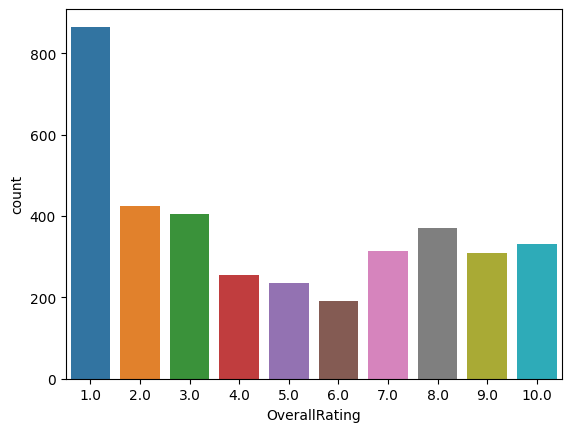

In [9]:
sns.countplot(df['OverallRating'])

In [10]:
df['OverallRating'].value_counts()

1.0     865
2.0     424
3.0     406
8.0     370
10.0    330
7.0     313
9.0     310
4.0     254
5.0     234
6.0     190
Name: OverallRating, dtype: int64

<AxesSubplot:>

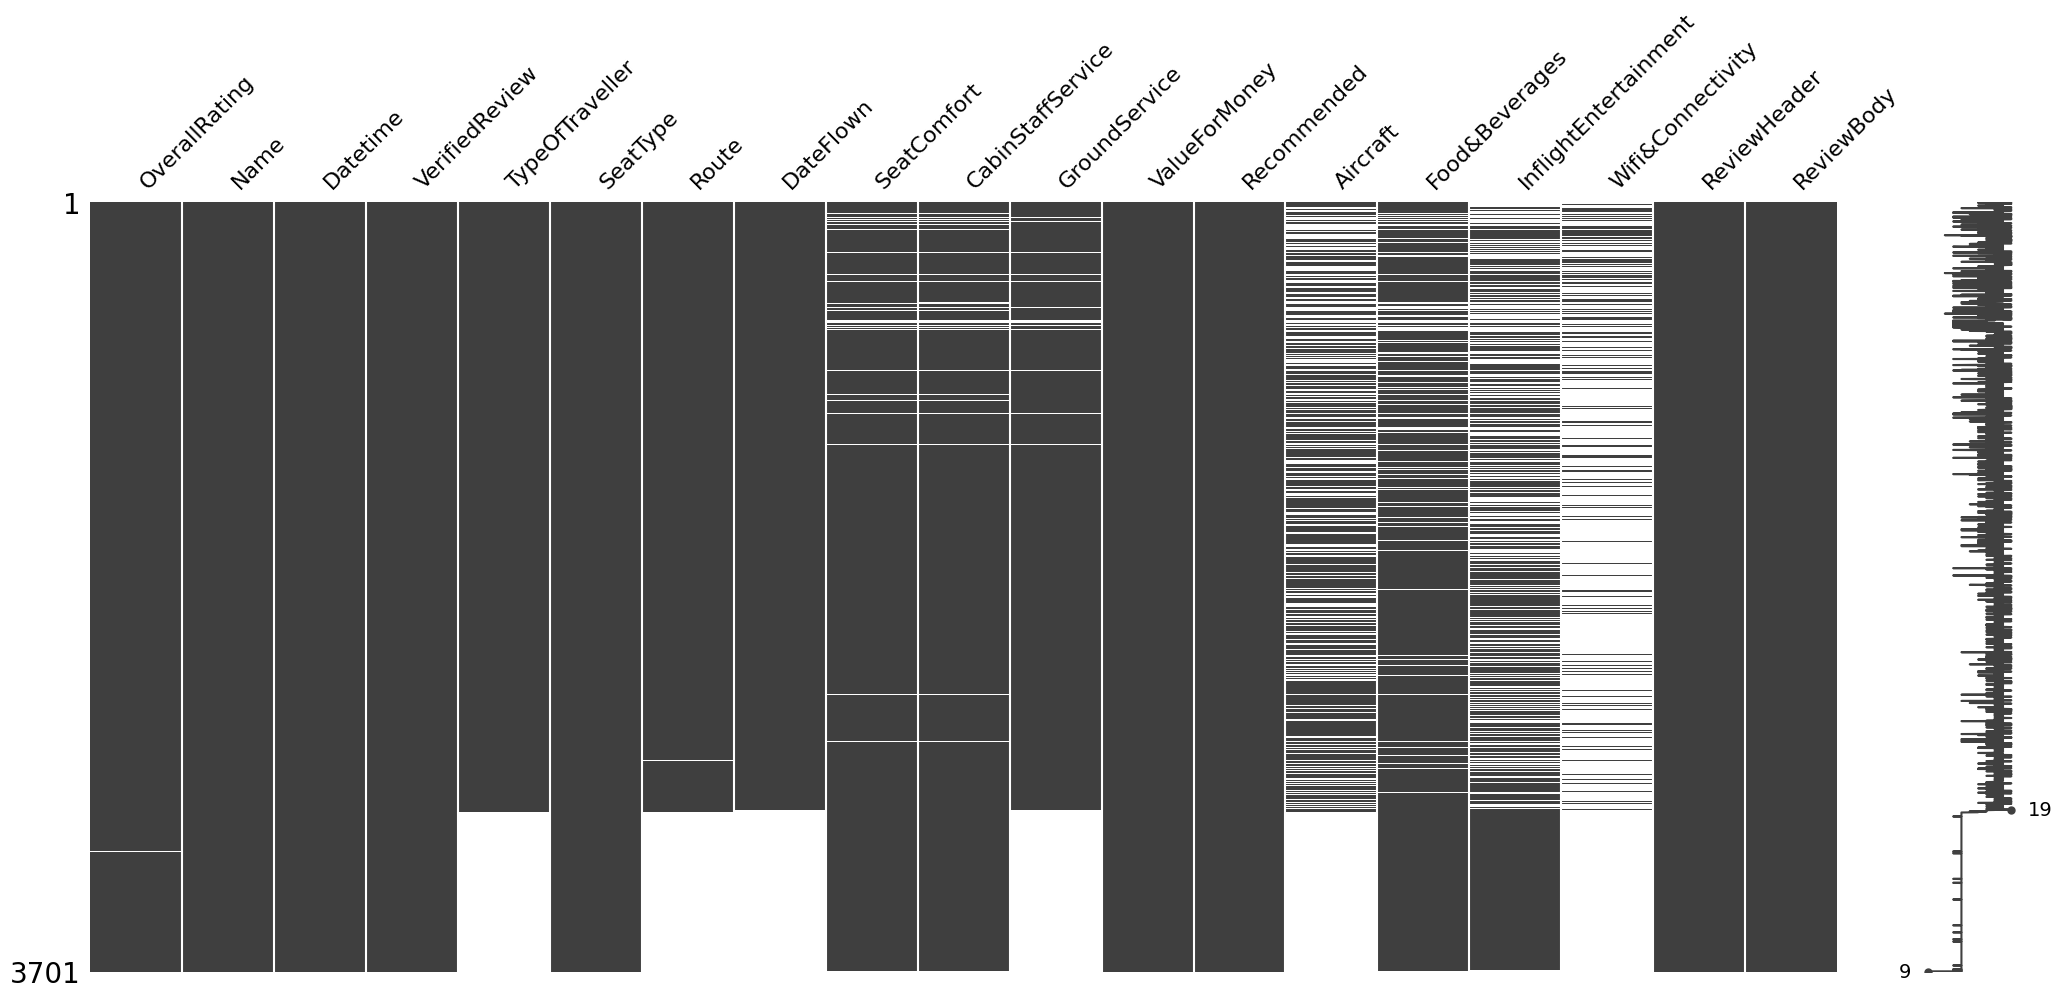

In [11]:
msno.matrix(df)

<AxesSubplot:>

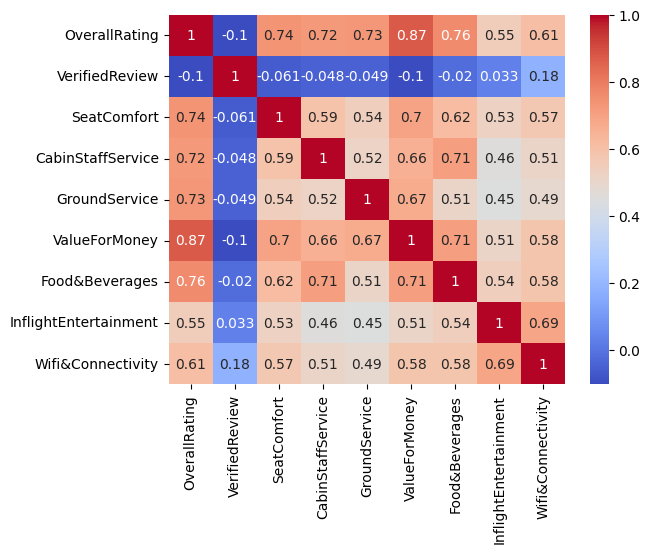

In [12]:
sns.heatmap(df.select_dtypes(exclude='object').corr(), cmap='coolwarm', annot=True)

In [13]:
df.VerifiedReview.value_counts()

False    2548
True     1153
Name: VerifiedReview, dtype: int64

<AxesSubplot:>

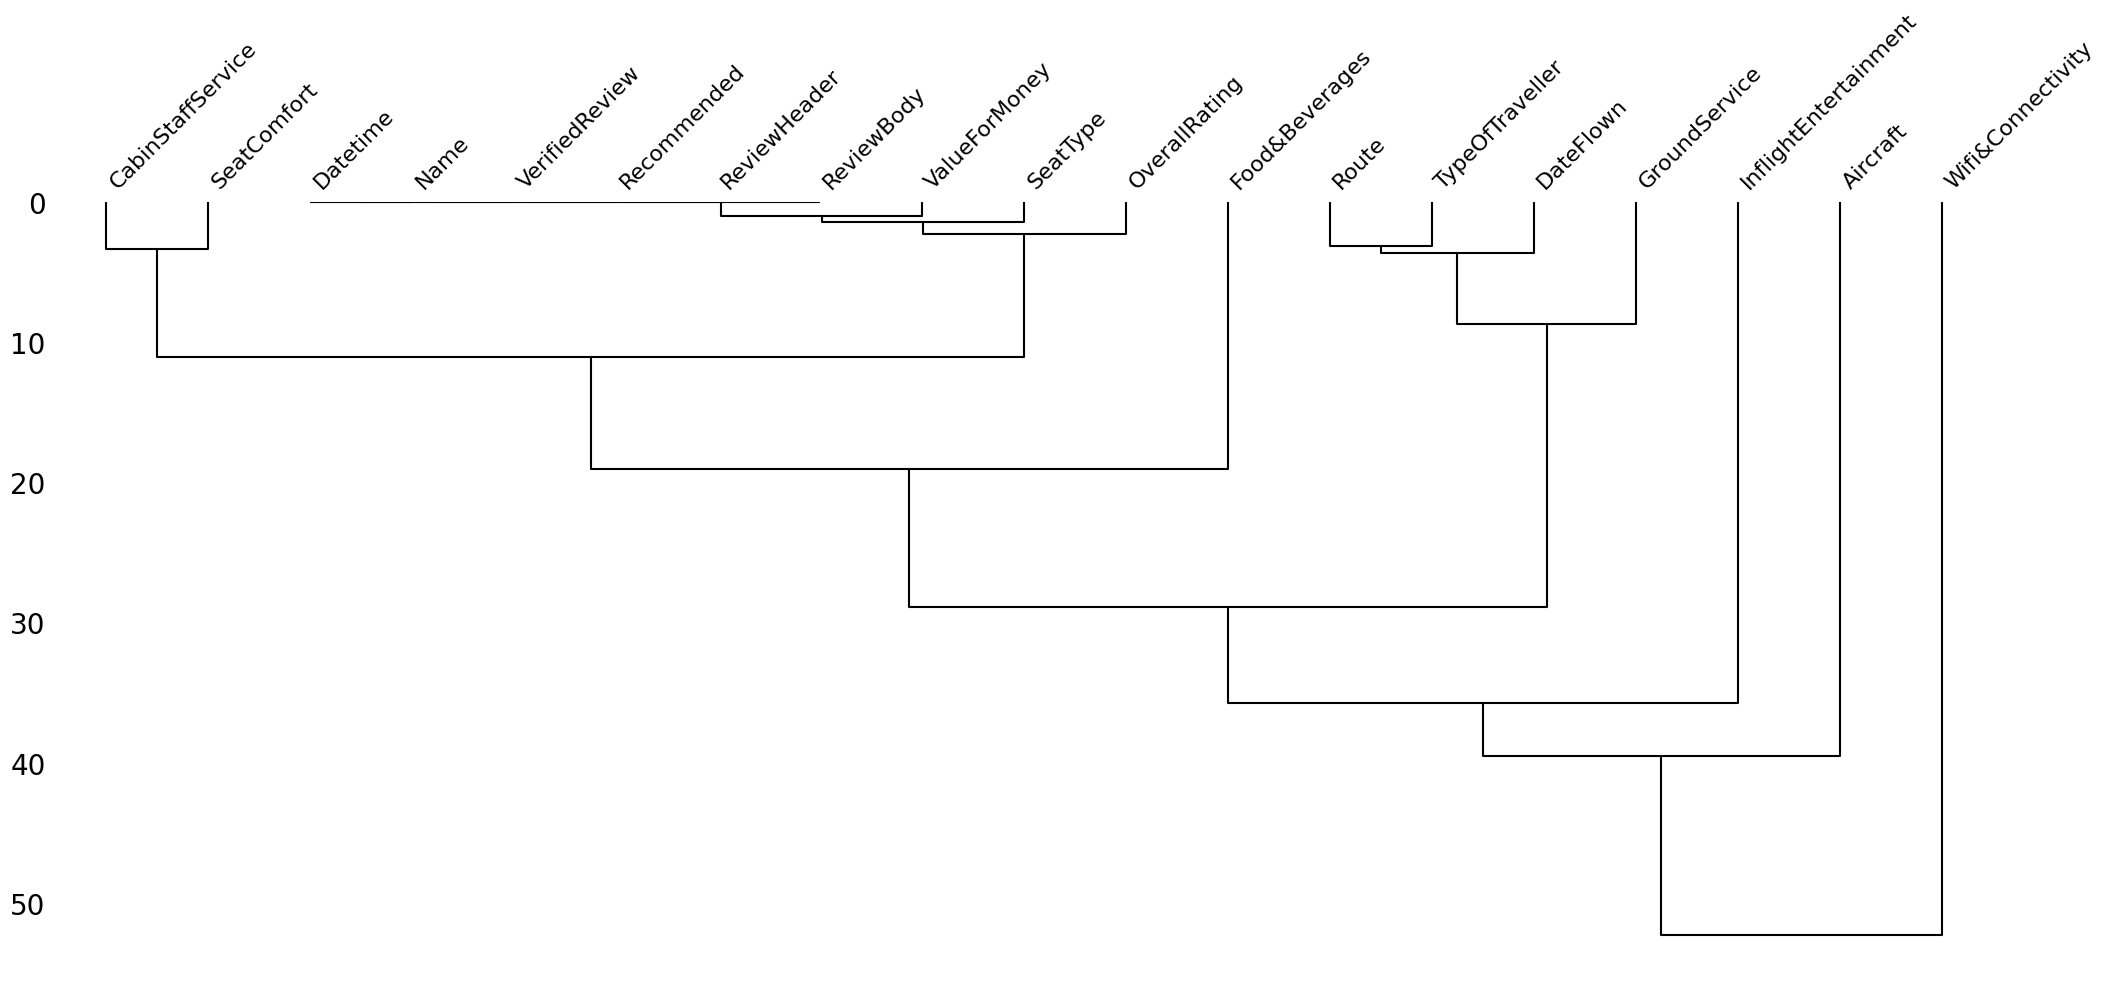

In [14]:
msno.dendrogram(df)

### Investigate reviews

In [15]:
df.ReviewHeader[7]

'“crew were polite”'

In [16]:
df['SimplifiedRating'] = df['OverallRating'].apply(lambda rating: 0 if rating < 7 else 1 if rating < 9 else 2)

<AxesSubplot:xlabel='SimplifiedRating', ylabel='count'>

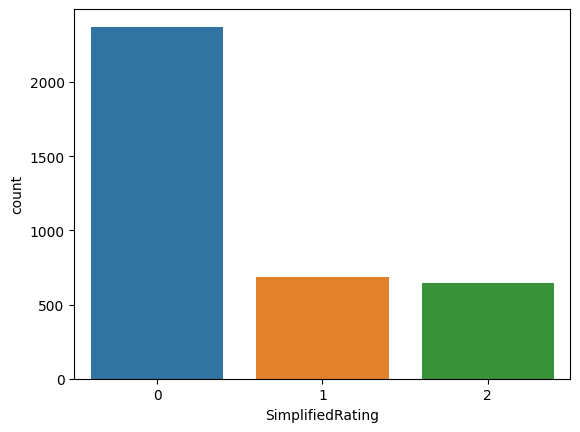

In [17]:
sns.countplot(df.SimplifiedRating)

In [18]:
# sentence_1 = 'This movie was awful'
# sentence_2 = 'I loved every moment of this movie!'
# sentence_3 = 'I want a refund; I was so bored!'

# X_eg = [sentence_1, sentence_2, sentence_3]
# y_eg = np.array([0., 1., 0.])
# type(y)

In [19]:
X, y = np.array(df.ReviewHeader), np.array(df.SimplifiedRating)

In [20]:
#Need to clean and remove stopwords
X[23]


'"2½ hours before the bags finally arrived" '

In [21]:
def get_tokenized_data(X, y):
    
    assert len(X) == len(y)

    ### Let's tokenize the vocabulary 
    tk = Tokenizer()
    tk.fit_on_texts(X)
    vocab = tk.word_index
    vocab_size = len(tk.word_index)
    print(f'There are {vocab_size} different words in your corpus')
#     print(tk.word_index)
    X_token = tk.texts_to_sequences(X)
    

    ### Pad the inputs
    X_pad = pad_sequences(X_token, dtype='float32', padding='pre')
    
    return X_pad, y, vocab_size, vocab

X_pad, y, vocab_size, vocab = get_tokenized_data(X, y)
print("X_pad.shape", X_pad.shape)
X_pad

There are 2024 different words in your corpus
X_pad.shape (3701, 13)


array([[  0.,   0.,   0., ..., 141., 670., 132.],
       [  0.,   0.,   0., ..., 970.,  27., 671.],
       [  0.,   0.,   0., ..., 448.,  10., 383.],
       ...,
       [  0.,   0.,   0., ...,   1.,   3.,   4.],
       [  0.,   0.,   0., ...,   1.,   3.,   4.],
       [  0.,   0.,   0., ...,   1.,   3.,   4.]], dtype=float32)

In [22]:
vocab

{'airways': 1,
 'british': 2,
 'customer': 3,
 'review': 4,
 'a': 5,
 'the': 6,
 'was': 7,
 'service': 8,
 'to': 9,
 'and': 10,
 'ba': 11,
 'very': 12,
 'flight': 13,
 'not': 14,
 'is': 15,
 'crew': 16,
 'of': 17,
 'experience': 18,
 'airline': 19,
 'i': 20,
 'in': 21,
 'for': 22,
 'with': 23,
 'good': 24,
 'were': 25,
 'no': 26,
 'on': 27,
 'my': 28,
 'cabin': 29,
 'food': 30,
 'again': 31,
 'seats': 32,
 'friendly': 33,
 'staff': 34,
 'are': 35,
 'worst': 36,
 'have': 37,
 'fly': 38,
 'this': 39,
 'seat': 40,
 'class': 41,
 'never': 42,
 'an': 43,
 'at': 44,
 'cost': 45,
 'be': 46,
 'they': 47,
 'had': 48,
 'business': 49,
 'so': 50,
 'poor': 51,
 'has': 52,
 'it': 53,
 'really': 54,
 'disappointed': 55,
 'excellent': 56,
 'will': 57,
 'all': 58,
 'budget': 59,
 'by': 60,
 'as': 61,
 'low': 62,
 'great': 63,
 'me': 64,
 'money': 65,
 'overall': 66,
 'economy': 67,
 'than': 68,
 'time': 69,
 'comfortable': 70,
 'uncomfortable': 71,
 'efficient': 72,
 'just': 73,
 'them': 74,
 'their':

### Word2Vec - using training data only

In [23]:
!pip freeze | grep gensim

gensim==4.2.0


In [24]:
!pip freeze | grep tensorflow

tensorflow==2.10.0
tensorflow-datasets==4.6.0
tensorflow-estimator==2.10.0
tensorflow-io-gcs-filesystem==0.27.0
tensorflow-metadata==1.10.0


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [26]:
X_train

array(['"Boarding was chaotic"', 'British Airways customer review',
       'British Airways customer review', ...,
       '"cramped seat with no lights"', 'British Airways customer review',
       'British Airways customer review'], dtype=object)

In [27]:
y_train

array([0, 2, 0, ..., 0, 1, 2])

In [28]:
len(X_train)

2590

In [29]:
###########################################
### Just run this cell to load the data ###
###########################################


def load_data(X_train, X_test, y_train, y_test, percentage_of_sentences=None):
    
    # Take only a given percentage of the entire data
    if percentage_of_sentences is not None:
        assert(percentage_of_sentences> 0 and percentage_of_sentences<=100)
        
        len_train = int(percentage_of_sentences/100*len(X_train))
        X_train, y_train = X_train[:len_train], y_train[:len_train]
  
        len_test = int(percentage_of_sentences/100*len(X_test))
        X_test, y_test = X_test[:len_test], y_test[:len_test]

    
    X_train = [text_to_word_sequence(_) for _ in X_train]
    X_test = [text_to_word_sequence(_) for _ in X_test]
    
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_data(X_train, X_test, y_train, y_test, percentage_of_sentences=100)

In [30]:
len(y_train)
# y_test


2590

In [31]:
len(X_train)
# X_train

2590

In [32]:
print(list(gensim.downloader.info()['models'].keys()))



['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [33]:
model_wiki = gensim.downloader.load('glove-wiki-gigaword-50')

len(model_wiki.key_to_index)

400000

In [34]:
vocab

{'airways': 1,
 'british': 2,
 'customer': 3,
 'review': 4,
 'a': 5,
 'the': 6,
 'was': 7,
 'service': 8,
 'to': 9,
 'and': 10,
 'ba': 11,
 'very': 12,
 'flight': 13,
 'not': 14,
 'is': 15,
 'crew': 16,
 'of': 17,
 'experience': 18,
 'airline': 19,
 'i': 20,
 'in': 21,
 'for': 22,
 'with': 23,
 'good': 24,
 'were': 25,
 'no': 26,
 'on': 27,
 'my': 28,
 'cabin': 29,
 'food': 30,
 'again': 31,
 'seats': 32,
 'friendly': 33,
 'staff': 34,
 'are': 35,
 'worst': 36,
 'have': 37,
 'fly': 38,
 'this': 39,
 'seat': 40,
 'class': 41,
 'never': 42,
 'an': 43,
 'at': 44,
 'cost': 45,
 'be': 46,
 'they': 47,
 'had': 48,
 'business': 49,
 'so': 50,
 'poor': 51,
 'has': 52,
 'it': 53,
 'really': 54,
 'disappointed': 55,
 'excellent': 56,
 'will': 57,
 'all': 58,
 'budget': 59,
 'by': 60,
 'as': 61,
 'low': 62,
 'great': 63,
 'me': 64,
 'money': 65,
 'overall': 66,
 'economy': 67,
 'than': 68,
 'time': 69,
 'comfortable': 70,
 'uncomfortable': 71,
 'efficient': 72,
 'just': 73,
 'them': 74,
 'their':

In [35]:
# model_wiki.key_to_index

In [36]:
missing_words = {k for k in vocab if not(k in model_wiki.key_to_index)}
selected_vocab = {k: v for (k, v) in vocab.items() if k in model_wiki.key_to_index}

In [37]:
# missing_words #Cleaning up the reviews will significantly reduce this
# selected_vocab

In [38]:
X_train[10]

['the', 'most', 'miserable', 'rip', 'off']

In [39]:
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import text_to_word_sequence



# word2vec = Word2Vec(sentences=X_train)
word2vec2 = Word2Vec(sentences= X_train)

wv = word2vec2.wv

In [40]:
wv.most_similar(['friendly'])

[('and', 0.9978986978530884),
 ('for', 0.9978305697441101),
 ('service', 0.9977620840072632),
 ('crew', 0.9977176785469055),
 ('at', 0.9975954294204712),
 ('ba', 0.9975918531417847),
 ('with', 0.9975693225860596),
 ('very', 0.99756920337677),
 ('the', 0.9975690245628357),
 ('a', 0.9974943399429321)]

In [41]:
wv['friendly'].shape

(100,)

In [42]:
# word2vec_3 = Word2Vec(sentences=X_train, vector_size=1000, min_count=6)
# wv_3 = word2vec_3.wv

# word2vec_4 = Word2Vec(sentences=X_train, vector_size=1000, min_count=4)
# wv_4 = word2vec_4.wv

# len(wv_3.key_to_index), len(wv_4.key_to_index)

In [43]:
# word2vec_5 = Word2Vec(sentences=X_train, vector_size=1000, min_count=6, window=2)
# wv_5 = word2vec_5.wv

In [44]:
w2vvocab = list(wv.key_to_index)
len(w2vvocab), len(vocab)

(341, 2024)

### Using pretrained embedding

In [45]:
# import gensim.downloader

# print(list(gensim.downloader.info()['models'].keys()))

# model_wiki = gensim.downloader.load('glove-wiki-gigaword-50')

In [46]:
# len(selected_vocab)

In [47]:
# model_wiki['airways'].shape

In [48]:
# len(X_train), len(X_test), len(y_train), len(y_test)

In [49]:
# def flatten(xss):
#     return [x for xs in xss for x in xs]

# # corpus = flatten(X_test)
# len(set(flatten(X_train))), len(set(flatten(X_test))) #How many unique words are contained in each of X_train and X_test?

In [50]:
# def embed_sentence(model, sentence):
#     token_words = []
#     for word in sentence:
#         try:
#             token_words.append(model[word])
#         except:
#             pass
#     return np.stack(np.array(token_words), axis=0)

In [51]:
# def embedding(model, sentences):
#     embedded_sentences = []
#     for sentence in sentences:
#         embedded_sentences.append(embed_sentence(model, sentence))
#     return embedded_sentences

In [52]:
# first_embedding = embed_sentence(model_wiki, X_train[16])
# first_embedding.shape


In [53]:
# for word in X_train[16]: #16, 21, 31, 43 all contain missing words
#     print(word in selected_vocab)
    
# X_train[16], len(X_train[16])

In [54]:
# X_train_embedded = embedding(model_wiki, X_train)
# X_test_embedded = embedding(model_wiki, X_test)

In [55]:
# X_train_embedded[0].shape

In [56]:
# X_train_pad = utils.pad_sequences(
#     X_train_embedded,
#     dtype='float32',
#     padding='pre',
#     maxlen= 200

# )

# X_test_pad = utils.pad_sequences(
#     X_test_embedded,
#     dtype='float32',
#     padding='pre',
#     maxlen= 200
# )

# assert(len(X_train_pad.shape) == 3)
# assert(len(X_test_pad.shape) == 3)
# assert(X_train_pad.shape[2] == 50)
# assert(X_test_pad.shape[2] == 50)

In [57]:
# X_test_pad.shape

#### Baseline Model

In this case, the baseline can be to predict the label that is the most present in `y_train` (of course, if the dataset is balanced, the baseline accuracy is 1/n where n is the number of classes - 3 here).

In [58]:
from sklearn.metrics import accuracy_score

unique, counts = np.unique(y_train, return_counts=True)
counts = dict(zip(unique, counts))
print('Number of labels in train set', counts)

y_pred = np.argmax([counts[i] for i in counts])

print('Baseline accuracy: ', accuracy_score(y_test, [y_pred]*len(y_test)))

Number of labels in train set {0: 1655, 1: 493, 2: 442}
Baseline accuracy:  0.6462646264626463


#### One hot encoding the target

In [59]:
y_train_cat, y_test_cat = utils.to_categorical(y_train), utils.to_categorical(y_test)

In [60]:
y_train_cat

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

#### Model training

In [61]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers

def init_model():
    model = Sequential()
    model.add(layers.Masking())
    model.add(layers.LSTM(20, activation='tanh'))
    model.add(layers.Dense(15, activation='relu'))
    model.add(layers.Dense(3, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    return model

model = init_model()

2024-03-27 11:33:25.535306: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-03-27 11:33:25.535415: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2024-03-27 11:33:25.535518: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-12451Q9): /proc/driver/nvidia/version does not exist
2024-03-27 11:33:25.536105: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [62]:
# from tensorflow.keras.callbacks import EarlyStopping

# es = EarlyStopping(patience=5, restore_best_weights=True)

# model.fit(X_train_pad, y_train_cat, 
#           batch_size = 32,
#           epochs=100,
#           validation_split=0.3,
#           callbacks=[es]
#          )

In [63]:
# res = model.evaluate(X_test_pad, y_test_cat, verbose=0)

# print(f'The accuracy evaluated on the test set is of {res[1]*100:.3f}%')

### Transfer learning

In [64]:
import gensim.downloader as api
print(list(api.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [65]:
word2vec_transfer = api.load("glove-wiki-gigaword-50")

In [66]:
print(len(word2vec_transfer.key_to_index))
print(len(word2vec_transfer['dog']))

400000
50


In [67]:
# Function to convert a sentence (list of words) into a matrix representing the words in the embedding space
def embed_sentence_with_TF(word2vec, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in word2vec:
            embedded_sentence.append(word2vec[word])
        
    return np.array(embedded_sentence)

# Function that converts a list of sentences into a list of matrices
def embedding(word2vec, sentences):
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence_with_TF(word2vec, sentence)
        embed.append(embedded_sentence)
        
    return embed

# Embed the training and test sentences
X_train_embed_2 = embedding(word2vec_transfer, X_train)
X_test_embed_2 = embedding(word2vec_transfer, X_test)

In [68]:
# Pad the training and test embedded sentences
X_train_pad_2 = pad_sequences(X_train_embed_2, dtype='float32', padding='post', maxlen=200)
X_test_pad_2 = pad_sequences(X_test_embed_2, dtype='float32', padding='post', maxlen=200)

In [69]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=5, restore_best_weights=True)

model = init_model()

model.fit(X_train_pad_2, y_train_cat, 
          batch_size = 32,
          epochs=10,
          validation_split=0.3,
          callbacks=[es]
         )

Epoch 1/10
57/57 [==============================] - 9s 95ms/step - loss: 0.9169 - accuracy: 0.6374 - val_loss: 0.8797 - val_accuracy: 0.6311
Epoch 2/10
57/57 [==============================] - 5s 83ms/step - loss: 0.8402 - accuracy: 0.6435 - val_loss: 0.8307 - val_accuracy: 0.6324
Epoch 3/10
57/57 [==============================] - 5s 82ms/step - loss: 0.7916 - accuracy: 0.6650 - val_loss: 0.7875 - val_accuracy: 0.6542
Epoch 4/10
57/57 [==============================] - 5s 83ms/step - loss: 0.7605 - accuracy: 0.6794 - val_loss: 0.7659 - val_accuracy: 0.6710
Epoch 5/10
57/57 [==============================] - 5s 83ms/step - loss: 0.7374 - accuracy: 0.6937 - val_loss: 0.7480 - val_accuracy: 0.6787
Epoch 6/10
57/57 [==============================] - 5s 83ms/step - loss: 0.7207 - accuracy: 0.6987 - val_loss: 0.7384 - val_accuracy: 0.6735
Epoch 7/10
57/57 [==============================] - 5s 87ms/step - loss: 0.7092 - accuracy: 0.6981 - val_loss: 0.7316 - val_accuracy: 0.6722
Epoch 8/10
57

In [70]:
res = model.evaluate(X_test_pad, y_test_cat, verbose=0)

print(f'The accuracy evaluated on the test set is of {res[1]*100:.3f}%')

NameError: name 'X_test_pad' is not defined